## Este es un Análisis Exploratorio de Datos y modelo de regresión aplicado a House Price

El proyecto se realizó a través de los siguientes pasos:
    
1. **Análisis exploratorio de datos**
    * 1.1 Exploración general
    * 1.2 Features Numericas
        * Exploración y limpieza de feature numéricas.
        * Datos faltante de features numéricos
    * 1.3 Features Categóricas
        * Exploración y limpieza de features categóricos
        * Datos faltantes de features categóricas.
        * Transformación de features categóricas en features binarias (get dummies)
    * 1.4 Fusión de features numéricas y binarias en un solo conjunto de datoss
    * 1.5 Eliminación de outliers desde el dataset train

2. **Ingeniería de caracteristicas**

3. **Preparacion de datos para el modelamiento**
    * 3.1 Variable objetivo 'SalesPrice'
    * 3.2 Cortando datos dentro de train y test estandarizados
    * 3.3 Regresión por pasos hacia atrás (Backward Stepwise Regression)
    * 3.4 Factor de inflación de varianza
    * 3.5 Distancia de Cook
4. **Modelamiento**
    * 4.1 Modelos y métricas de selección
    * 4.2 Ajuste de parámetros y optimización del modelo
        * Ridge Regression
        * Lasso Regression
        * XGBoost Regression
        * LightGBM Regression
    * 4.3 Elección del mejor modelo
    * 4.4 Predicción sobre el dataset de testing test


#### Datasets:
El dataset train y test son importados desde la competición de Kaggle "House Price - Advanced Regression Techniques"

#### objetivo:
El obtjetivo de este kernel es elegir el mejor modelo de regresion que se ajuste al problema. Por lo tanto este proyecto empezará por la limpieza de datos, procesamiento de datos faltantes, selección de variables relevantes, deducción de algunos features, ejecución de pruebas estadísticas, definición de modelos de regresión y finalmente elejir el mejor modelo de predicción de precios en el dataset test.

# 1. Análisis exploratorio de Datos

Este análisi exploratorio e ingeniría de características son principalmente basadas en estos kernel de Kaggle:
* [Comprehensive data exploration with python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)

* [Detailed exploratory data analysis with python](https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python)

* [House price just with categorical features](https://www.kaggle.com/code/hosseinbehjat/house-price-just-with-categorical-features)

* [Handling missing values](https://www.kaggle.com/code/dansbecker/handling-missing-values)

### 1.1. Exploración general

#### Importamos y cargamos las librerías necesarias para el análisis de nuestros datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as norm

import missingno as msno
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

Cargamos los datasets:
* train.csv
* test.csv

In [2]:
df_train = pd.read_csv('Datasets/train.csv')
df_test = pd.read_csv('Datasets/test.csv')

#Imprimimos su dimensios o forma
print(f'Shape de train:\n {df_train.shape}')
print(f'Shape de test:\n {df_test.shape}')

Shape de train:
 (1460, 81)
Shape de test:
 (1459, 80)


Observamos la información de cada una de las variables de nuestros dataframes

In [3]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Se puede notar que muchas columnas tienen missing values (valores faltantes), los cuales trataremos mas adelante. 

#### Ahora vamos a comprobar si los encabezados de las columnas son los mismos en ambos dataframes df_train y df_test 

In [4]:
# List COmprehension
dif_1 = [x for x in df_train.columns if x not in df_test.columns]
dif_2 = [x for x in df_test.columns if x not in df_train.columns]

print("Las columnas presentes en df_train y ausentes en df_test son: ", dif_1, "\n")
print("Las columnas presentes en df_test y ausentes en df_train son: ", dif_2)

Las columnas presentes en df_train y ausentes en df_test son:  ['SalePrice'] 

Las columnas presentes en df_test y ausentes en df_train son:  []


Solo la columna o feature SalePrice es la que esta presente en el dataset df_train y no en el dataset df_train y eso es debido a que SalesPrices es la target variable u objetivo para ser predecida.

Normalmente el 80% de los datos se concentra en el dataset train (entrenamiento) y el 20% en dataset test (pruebas)

In [5]:
# Borramos el 'id' column desde el dataset train
df_train.drop(["Id"], axis = 1, inplace = True)

# Guardamos las lista de de "id" antes de elinar del dataset test
id_test_list = df_test['Id'].tolist()
df_test.drop(["Id"], axis = 1, inplace = True)


### 1.2. Features Numericas

#### Exploración y limpieza de features o variables numéricas

Seleccionamos las columnas del dataset de entrenamiento (train) con datos numéricos

In [6]:
# Guardamos en una nueva variable llamada df_train_num e imprimimos
df_train_num = df_train.select_dtypes(exclude = object)
df_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


En total son 37 columnas que contienen variables numéricas

Borramos columnas cuasi-constantes donde el 95% de valores son cuasiconstantes o similares.

In [7]:
# Creamos un objeto para elimininar columnas donde el 95% son constantes
sel = VarianceThreshold(threshold=0.05) 

# El método Fit encuentra las columnas con varianza constante
sel.fit(df_train_num.iloc[:,:-1])

# Se obtiene el numero de columnas que no son constantes
print('Número de features retenidas: ', sum(sel.get_support()))
print(f'Número de features cuasiconstantes: {len(df_train_num.iloc[:,:-1].columns) - sum(sel.get_support())}')

quasi_constant_features_list = [x for x in df_train_num.iloc[:, :-1].columns if x not in df_train_num.iloc[:, :-1].columns[sel.get_support()]]

print('Columnas cuasi constantes que son eliminadas: ', quasi_constant_features_list)

# Eliminamos estas columnas de df_train_num
df_train_num.drop(quasi_constant_features_list, axis = 1, inplace = True)

Número de features retenidas:  35
Número de features cuasiconstantes: 1
Columnas cuasi constantes que son eliminadas:  ['KitchenAbvGr']


Graficamos la distribución de todos los features numéricos

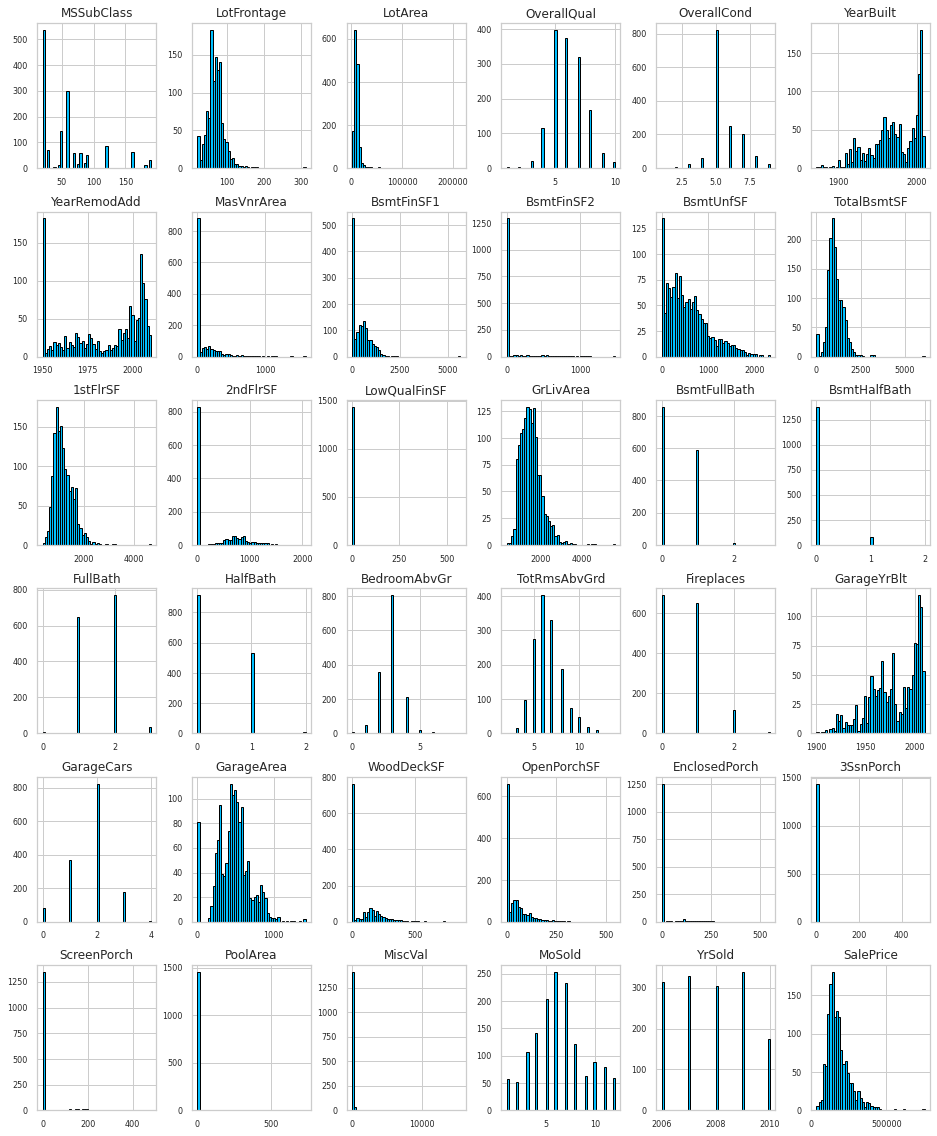

In [8]:
fig = df_train_num.hist(figsize = (16,20), bins = 50, color='deepskyblue',
                        edgecolor = 'black', xlabelsize = 8, ylabelsize = 8)

Graficamos un Heatmap para todas las variables numéricas incluyendo el target 'SalePrices'

<AxesSubplot:>

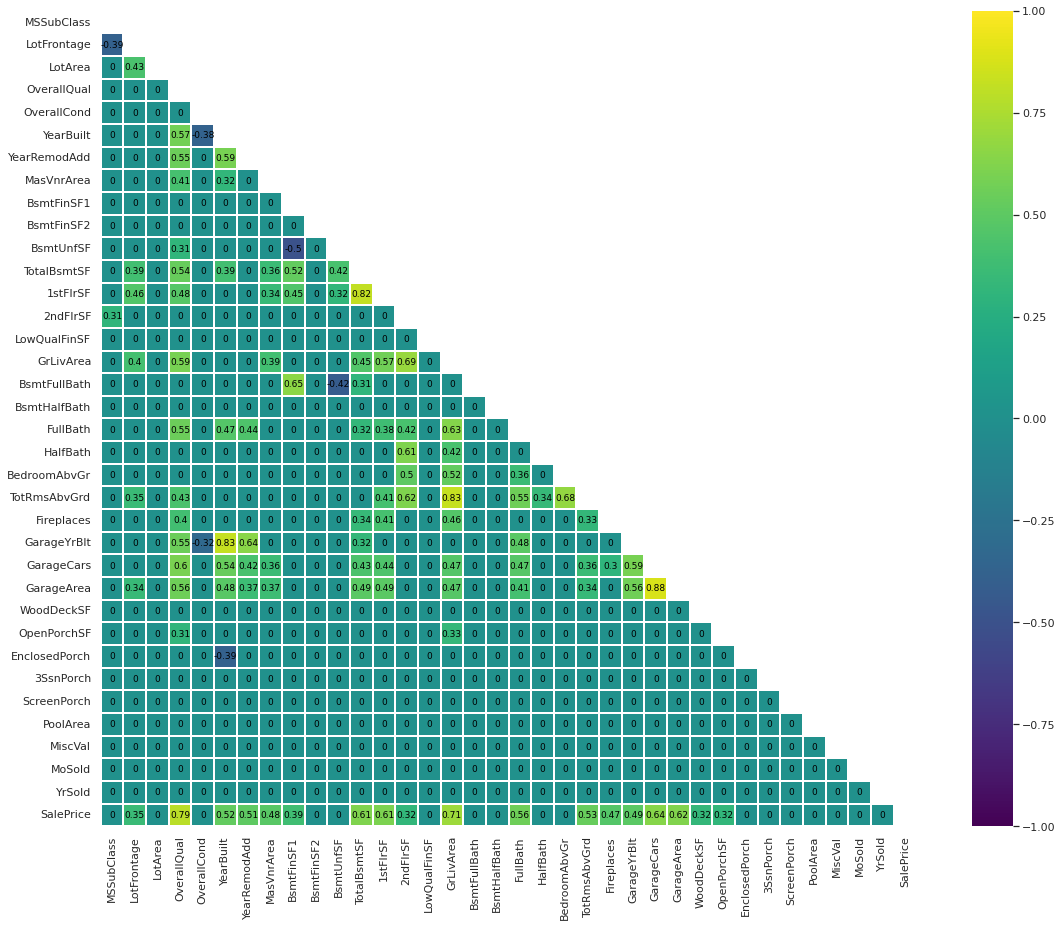

In [9]:
# Definiendo los parámetros de Heatmap
pd.options.display.float_format = "{:,.2f}".format

# Definimos la matriz de correlación
corr_matrix = df_train_num.corr()

# Reemplazamos las correlaciones menos que |0.3| por 0 para una mejor visibilidad
corr_matrix[(corr_matrix<0.3)&(corr_matrix>-0.3)] = 0

# Cubro las parte superior del Heatmap o mapa de calor
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Elejimos el color del mapa
cmap = "viridis"

# Graficamos el heatmap
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
           annot_kws={"size":9,"color": "black" }, square=True, cmap=cmap, annot=True)


A partir de la distribución de cada variable numérica así como la del Heatmap podemos notar que son importantes 18 features y están correlacionadas sin nuestra variable target 'SalesPrices' 

También podemos observar que muchas features está correlacionadas entre sí.Manejaremos éstas correlaciones mientras seleccionados las características para nuestro modelo.

In [10]:
# Seleccionamos features donde la correlación con 'SalePrice' es mayor que |0.3|. Es -1 porque la última columna es 'SalePrice'
df_num_corr = df_train_num.corr()['SalePrice'][:-1]

# Features correlacinadas (r2 > 0.5)
hight_features_list= df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending = False)

print(
f"{len(hight_features_list)} valores fuertemente correlacionados con 'SalePrice: \n{hight_features_list}\n'"
)

# Features correlacioadas (0.3 < r2 > 0.5)
low_features_list = df_num_corr[(abs(df_num_corr)<0.5) & (abs(df_num_corr)>=0.3)].sort_values(ascending=False)

print(
f"{len(low_features_list)} valores suavemente correlacionados con 'SalePrice: \n{low_features_list}\n'"
)

10 valores fuertemente correlacionados con 'SalePrice: 
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64
'
8 valores suavemente correlacionados con 'SalePrice: 
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64
'


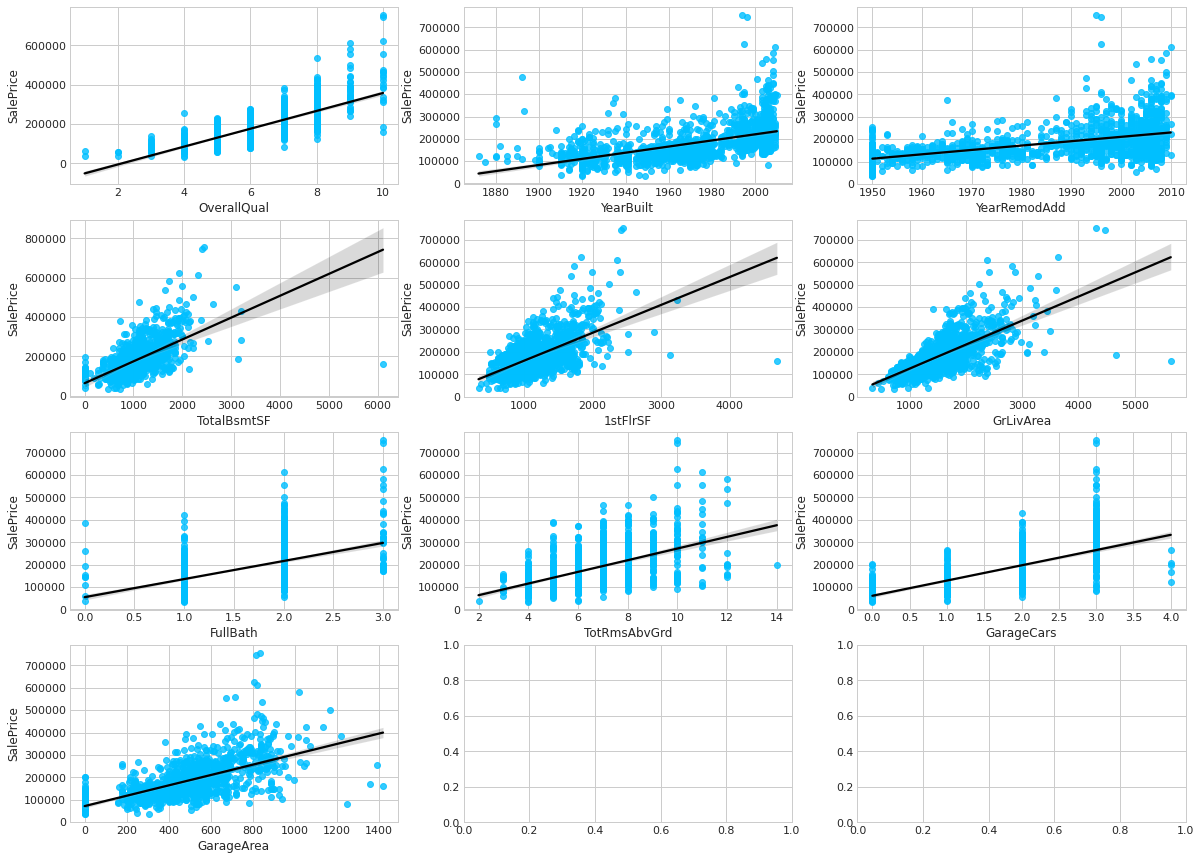

In [11]:
# Features con una alta correlación (mayor que 0.5)
strong_features = df_num_corr[abs(df_num_corr)>0.5].index.tolist()
# Añado el nombre de la target 'SalePrice'
strong_features.append('SalePrice')

# Defino un dataFrame con los features fuertemente correlacionados
df_strong_features = df_train_num.loc[:, strong_features]

# Defino un estilo para las figuras
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(round(len(strong_features)/3), 3)


for i, ax in enumerate(fig.axes):
    # Graficamos la correlación de cada feature con SalePrice. Recuerde que strong_feature es una lista
    if i < len(strong_features)-1:
        sns.regplot(x=strong_features[i], y="SalePrice", data=df_strong_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"})

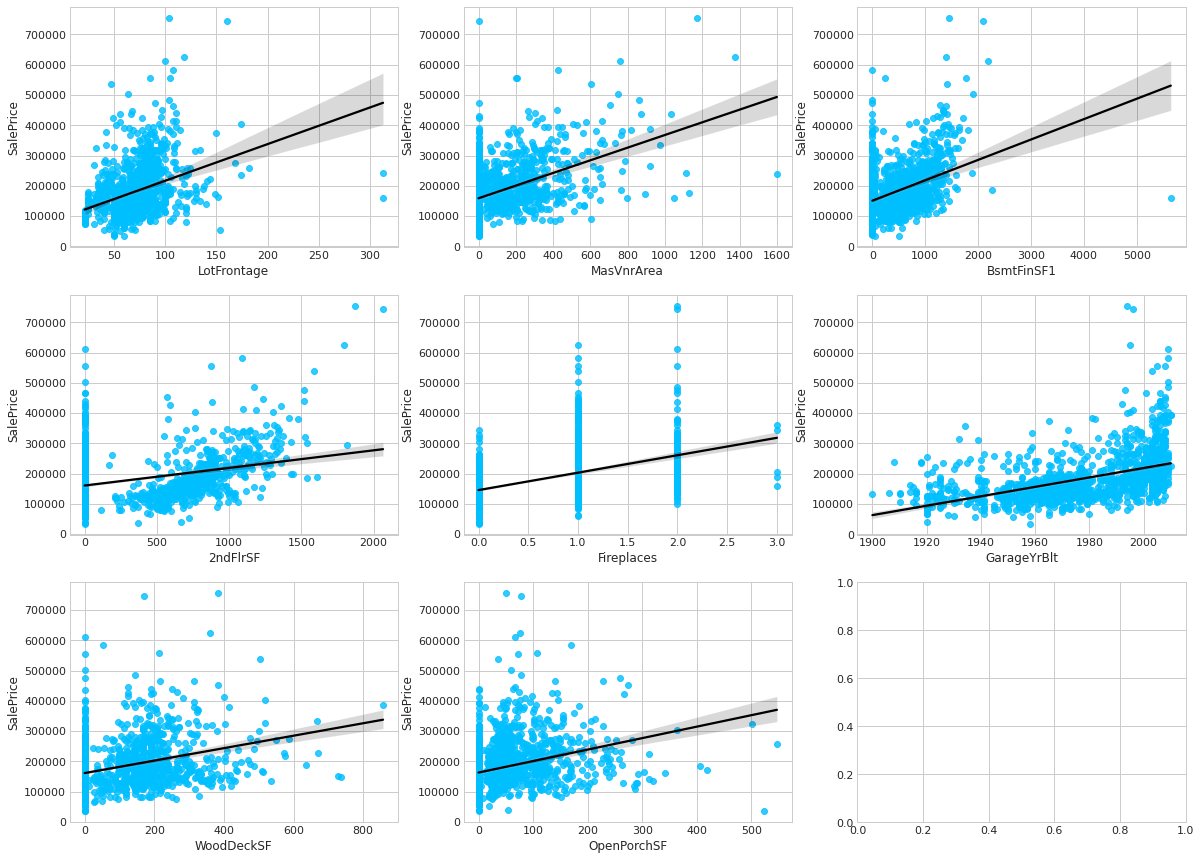

In [12]:
# Features con bajas correlaciones entre 0.3 y 0.5
low_features = df_num_corr[(abs(df_num_corr)>=0.3) & (abs(df_num_corr)<0.5)].index.tolist()
# Añadimos también SalesPrice
low_features.append('SalePrice')

# Definimos un dataFrame con los features encontrados con los datos
df_low_features = df_train_num.loc[:, low_features]

# Defino un estilo para las figuras
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(round(len(low_features)/3), 3)

for i, ax in enumerate(fig.axes):
    # Graficamos la correlación de cada feature con SalePrice. Recuerde que low_feature es una lista
    if i < len(low_features)-1:
        sns.regplot(x=low_features[i], y="SalePrice", data=df_low_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"})



In [13]:
# Definimos la lista de features numéricos a mantener
list_of_numerical_features = strong_features[:-1] + low_features

# Definimos nuestro nuevo data set de entrenamiento con las features seleccionadas
df_train_num = df_train_num.loc[:, list_of_numerical_features]

# Definimos nuestro nuevo data set de pruebas igualmente con las features seleccionadas (-1 excepto 'SalesPrice')
df_test_num = df_test.loc[:, list_of_numerical_features[:-1]]

Se mantuvo las 18 features más correlacionadas con 'SalesPrice'

### Datos Faltantes de features numéricas

Se chequeará los NaN del set de entrenamiento dibujando el porcentaje de valores faltantes por columna

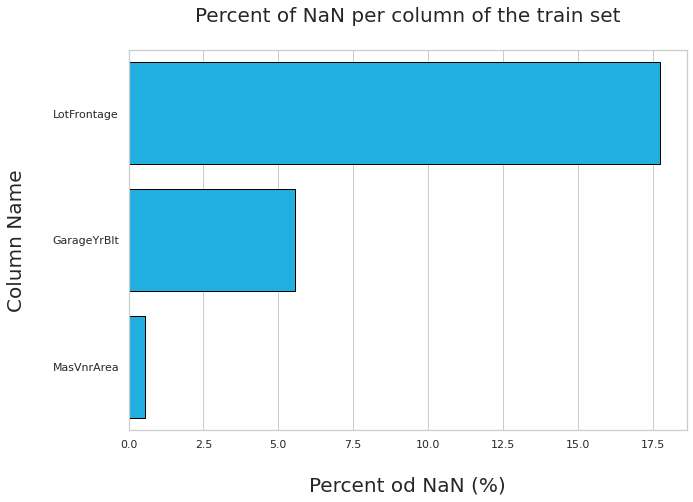

In [14]:
# Determino que columnas o features presentan valores NaN
column_with_nan = df_train_num.columns[df_train_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    # Sumo la cantidad de NaN por columna multilplico por cien y divido para la longitud total de la columna
    percent_nan.append(round(df_train_num[i].isnull().sum()*100/len(df_train_num), 2))

# Creamos un Dataframe con las colunmnas con valores NaN y sus respectivos porcentajes de valores NaN    
tab = pd.DataFrame(column_name, columns=['Column'])
tab['Percent_NaN'] = percent_nan
tab.sort_values(by = ['Percent_NaN'], ascending=False, inplace = True)


# Definios parametros de figura
sns.set(rc={"figure.figsize":(10,7)})
sns.set_style("whitegrid")

# Graficamos resultados
p = sns.barplot("Percent_NaN", y = "Column", data = tab,
                edgecolor = 'black', color = 'deepskyblue')

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent od NaN (%)", fontsize = 20)
p.set_ylabel("Column Name\n", fontsize = 20)
plt.show()


Imputación de valores faltantes NaN's con SimpleImputer

In [15]:
# Creamos un objeto de tipo SimpleImputer
my_imputer = SimpleImputer(strategy="median")

# Imputo el dataset df_train_num y defino un nueo dataset 
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(df_train_num))

# Reescribo columnas 
df_train_imputed.columns = df_train_num.columns

# Miramos si ahora existen valores falatantes
df_train_imputed.isnull().sum()


OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
2ndFlrSF        0
Fireplaces      0
GarageYrBlt     0
WoodDeckSF      0
OpenPorchSF     0
SalePrice       0
dtype: int64

Chequemos la distribución de cada features antes y después de la imputación

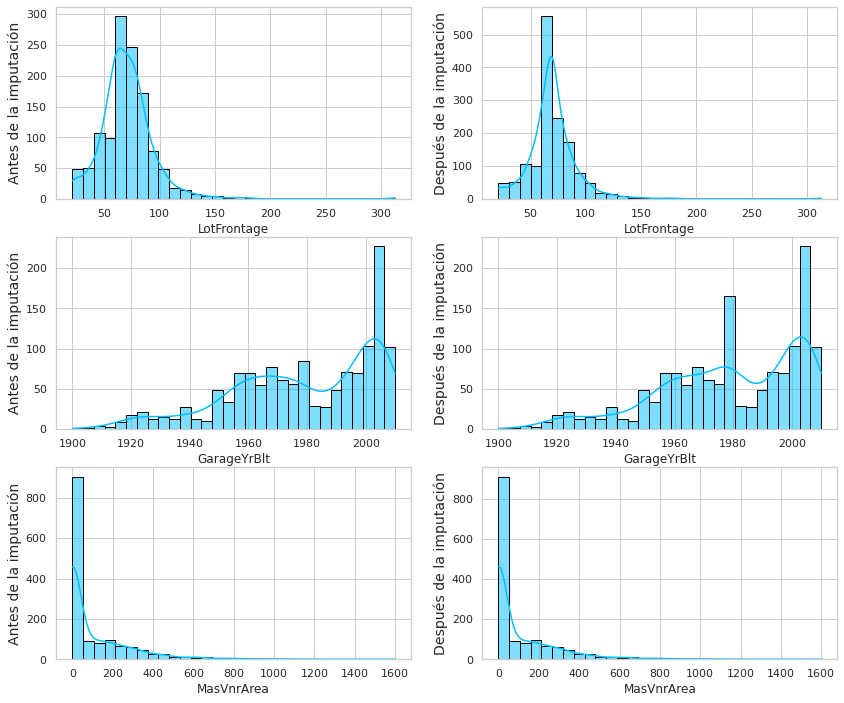

In [16]:
# Definimos los parámetros de la figura
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3,2)

# Graficamos los resultados
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0,1,2]):
    
    """ Ditribución de features antes y depués de la imputación"""
    
    # Antes la imputación
    p = sns.histplot(ax = axes[fig_pos, 0], x = df_train_num[feature],
                    kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    p.set_ylabel(f'Antes de la imputación', fontsize=14)
    
    # después de la imputación
    q = sns.histplot(ax = axes[fig_pos,1], x=df_train_imputed[feature],
                     kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    q.set_ylabel(f'Después de la imputación', fontsize=14) 

Para "LotFrontage", "GarageYrBlt" las distribuciones han cambiado después de la distribución. Pero no es así para la distribución de "MasVnrArea". Entonces se eliminarán las features que muestran cambios para evitar errores relacionadosa a la imputación y solo mantendrá "MasVnrArea" para el análisis. 

In [17]:
# Borramos "LotFrontage" y "GarageYrBlt"
df_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace = True)
df_train_imputed.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,Fireplaces,WoodDeckSF,OpenPorchSF,SalePrice
0,7.00,"2,003.00","2,003.00",856.00,856.00,"1,710.00",2.00,8.00,2.00,548.00,196.00,706.00,854.00,0.00,0.00,61.00,"208,500.00"
1,6.00,"1,976.00","1,976.00","1,262.00","1,262.00","1,262.00",2.00,6.00,2.00,460.00,0.00,978.00,0.00,1.00,298.00,0.00,"181,500.00"
2,7.00,"2,001.00","2,002.00",920.00,920.00,"1,786.00",2.00,6.00,2.00,608.00,162.00,486.00,866.00,1.00,0.00,42.00,"223,500.00"
3,7.00,"1,915.00","1,970.00",756.00,961.00,"1,717.00",1.00,7.00,3.00,642.00,0.00,216.00,756.00,1.00,0.00,35.00,"140,000.00"
4,8.00,"2,000.00","2,000.00","1,145.00","1,145.00","2,198.00",2.00,9.00,3.00,836.00,350.00,655.00,"1,053.00",1.00,192.00,84.00,"250,000.00"


Test dataset

Las columnas que han sido borradas en el set de entranemiento (train) también deben ser borradas en el set de prueba (test), para que los dos modelos permanezcan idénticos para el modelado y predicción.

In [18]:
# Borramos las mismas feutures "LotFrontage" y "GarageYrBlt" para nuestro set test
df_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace = True)

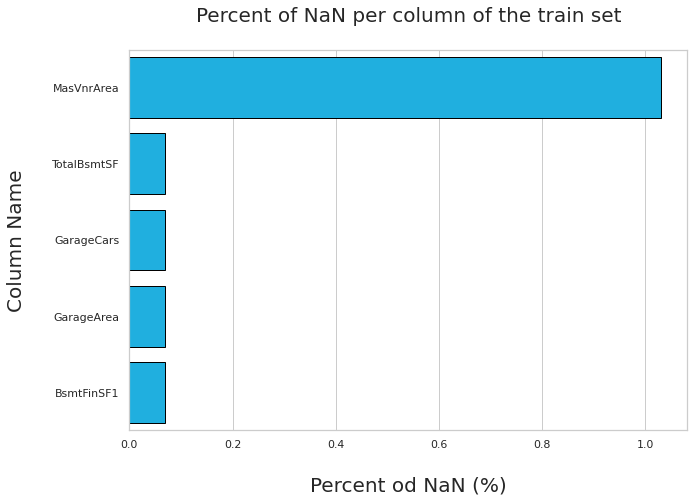

In [19]:
# chequeamos los NaN del set test para graficar el porcentaje de valores faltantes por columna
column_with_nan = df_test_num.columns[df_test_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    # Sumo la cantidad de NaN por columna multilplico por cien y divido para la longitud total de la columna
    percent_nan.append(round(df_test_num[i].isnull().sum()*100/len(df_test_num), 2))

# Creamos un Dataframe con las colunmnas con valores NaN y sus respectivos porcentajes de valores NaN    
tab = pd.DataFrame(column_name, columns=['Column'])
tab['Percent_NaN'] = percent_nan
tab.sort_values(by = ['Percent_NaN'], ascending=False, inplace = True)


# Definios parametros de figura
sns.set(rc={"figure.figsize":(10,7)})
sns.set_style("whitegrid")

# Graficamos resultados
p = sns.barplot("Percent_NaN", y = "Column", data = tab,
                edgecolor = 'black', color = 'deepskyblue')

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent od NaN (%)", fontsize = 20)
p.set_ylabel("Column Name\n", fontsize = 20)
plt.show()

Imputamos datos faltantes

In [20]:
# Realizamos la imputación de los valores faltantes con SimpleImputer
my_imputer = SimpleImputer(strategy="median")

# Imputo el dataset df_train_num y defino un nueo dataset 
df_test_imputed = pd.DataFrame(my_imputer.fit_transform(df_test_num))

# Reescribo columnas 
df_test_imputed.columns = df_test_num.columns

# Miramos si ahora existen valores falatantes
df_test_imputed.isnull().sum()



OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
MasVnrArea      0
BsmtFinSF1      0
2ndFlrSF        0
Fireplaces      0
WoodDeckSF      0
OpenPorchSF     0
dtype: int64

Chequeamos las distribuciones de cada distribución antes y después de la imputación

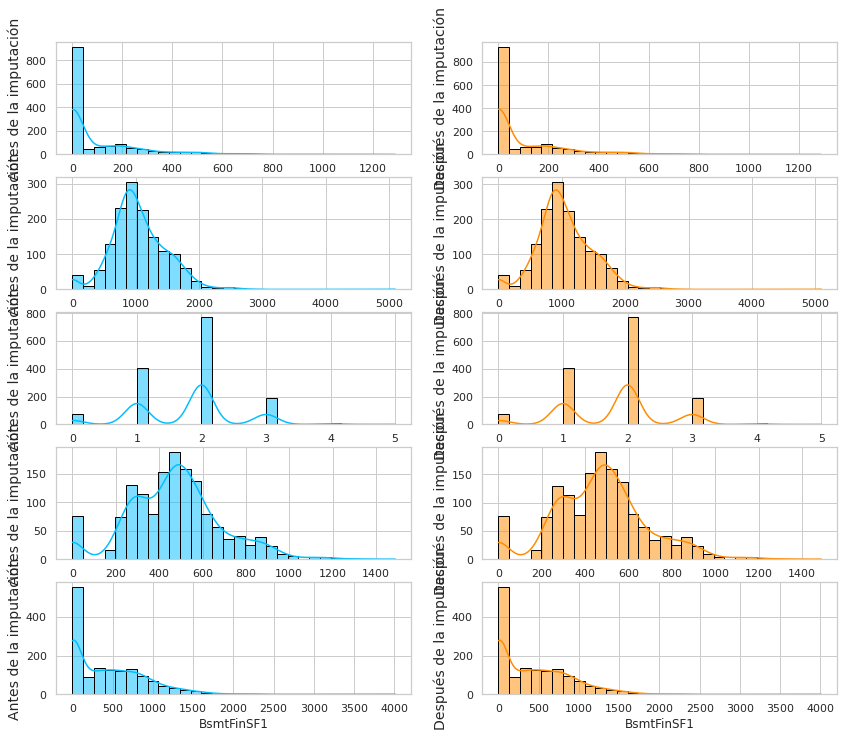

In [21]:
# Definimos los parámetros de la figura
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(5,2)

# Graficamos los resultados
for feature, fig_pos in zip(tab['Column'].tolist(), range(0,6)):
    
    """ Ditribución de features antes y depués de la imputación"""
    
    # Antes la imputación
    p = sns.histplot(ax = axes[fig_pos, 0], x = df_test_num[feature],
                    kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    p.set_ylabel(f'Antes de la imputación', fontsize=14)
    
    # después de la imputación
    q = sns.histplot(ax = axes[fig_pos,1], x=df_test_imputed[feature],
                     kde = True, bins=30, color = "darkorange", edgecolor = "black" )
    q.set_ylabel(f'Después de la imputación', fontsize=14)

Los porcentajes de NaN en cada uno de esto features no excede el 1.5%.Por lo tanto al imputar estos errores faltantes, pocos errores fueron introducidos y las distribucione fueron similares antes y después de la imputación.

### Features categóricas

#### Exploración y limpieza de features categóricas

In [22]:
# Tomamos features que sean solo de tipo 'object'.
categorical_features = [i for i in df_train.columns if df_train.dtypes[i] == 'object' ]

# Añadimos la feature cuantativa 'SalePrice'. Ojo que ésta feature es nuestra target
categorical_features.append('SalePrice')

# Creamos el set de entrenamieno de features categoricas.
df_train_categ = df_train[categorical_features]

# Creamos el set de pruebas de features categóricas
df_test_categ = df_test[categorical_features[:-1]]

Aplicamos un countplot() a cada una de las features categórcas en el set de entrenamiento categórico

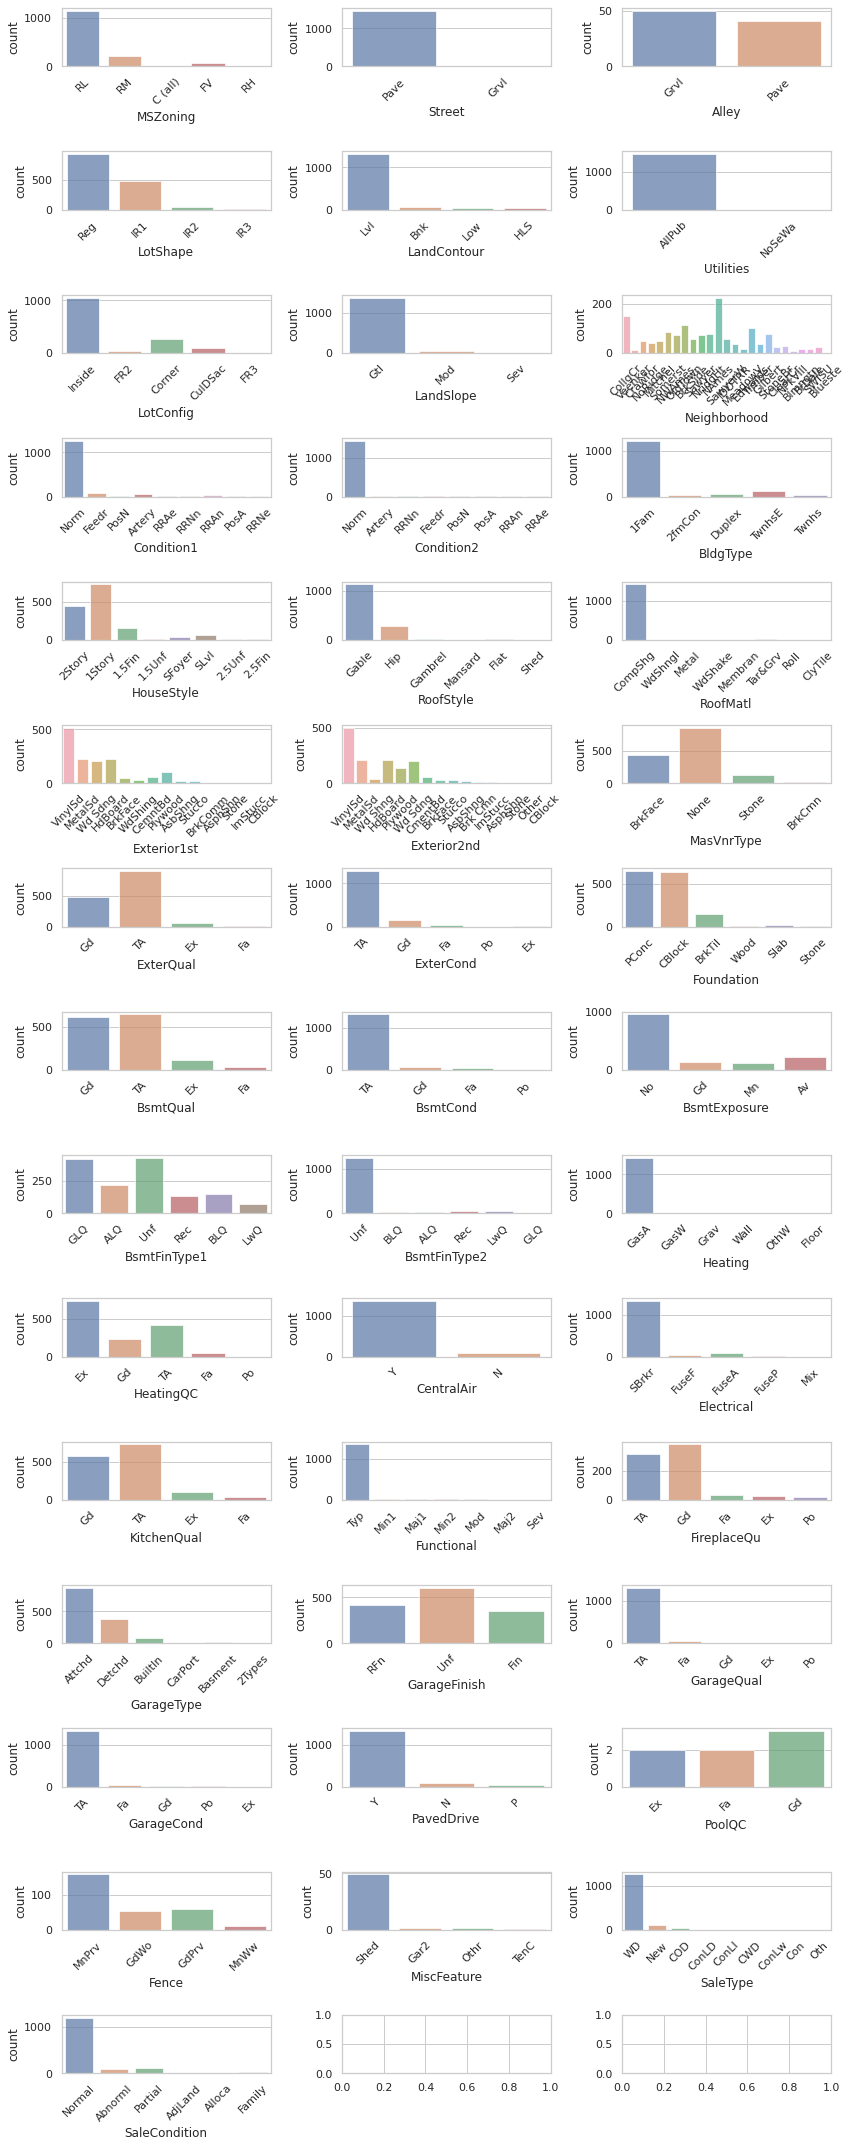

In [23]:
fig, axes = plt.subplots( round(len(df_train_categ.columns)/3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    # Graficamos un barplot para cada features
    if i < len(df_train_categ.columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 45)        
        sns.countplot(x=df_train_categ.columns[i], alpha = 0.7, data = df_train_categ, ax=ax)
        
fig.tight_layout()
        

Mirando cercanamente algunos de los count plots se puede notar que algunas de las features categorias las observaciones están concentradas en **un único nivel de categoría**. Estas características son menos informaticas para nuestro modelo de modo que sería mejor removerlas.

In [24]:
# Eliminamos algunas de las caractecrísticas NO informativas del set de entrenamiento y el set de pruebas
columns_to_drop = [
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Condition2",
    "RoofMatl",
    "CentralAir",
    "GarageQual",
    "GarageCond",
    "SaleType",
    "PavedDrive",
    "LandContour",
    "ExterCond",
    "GarageCond",
    "Heating",
    "MiscFeature",
    "BsmtFinType2",
    "Functional",
    "GarageQual",
    "GarageCond",
]

# Set de entrenamiento
df_train_categ.drop(columns_to_drop, axis = 1, inplace = True)
 
# Set de pruebas
df_test_categ.drop(columns_to_drop, axis = 1, inplace=True)

Con boxplot podemos ver la variación de nuestro target 'SalePrice' en cada una de las variables categóricas. Entonces aplicaremos este diagrama en cada una.

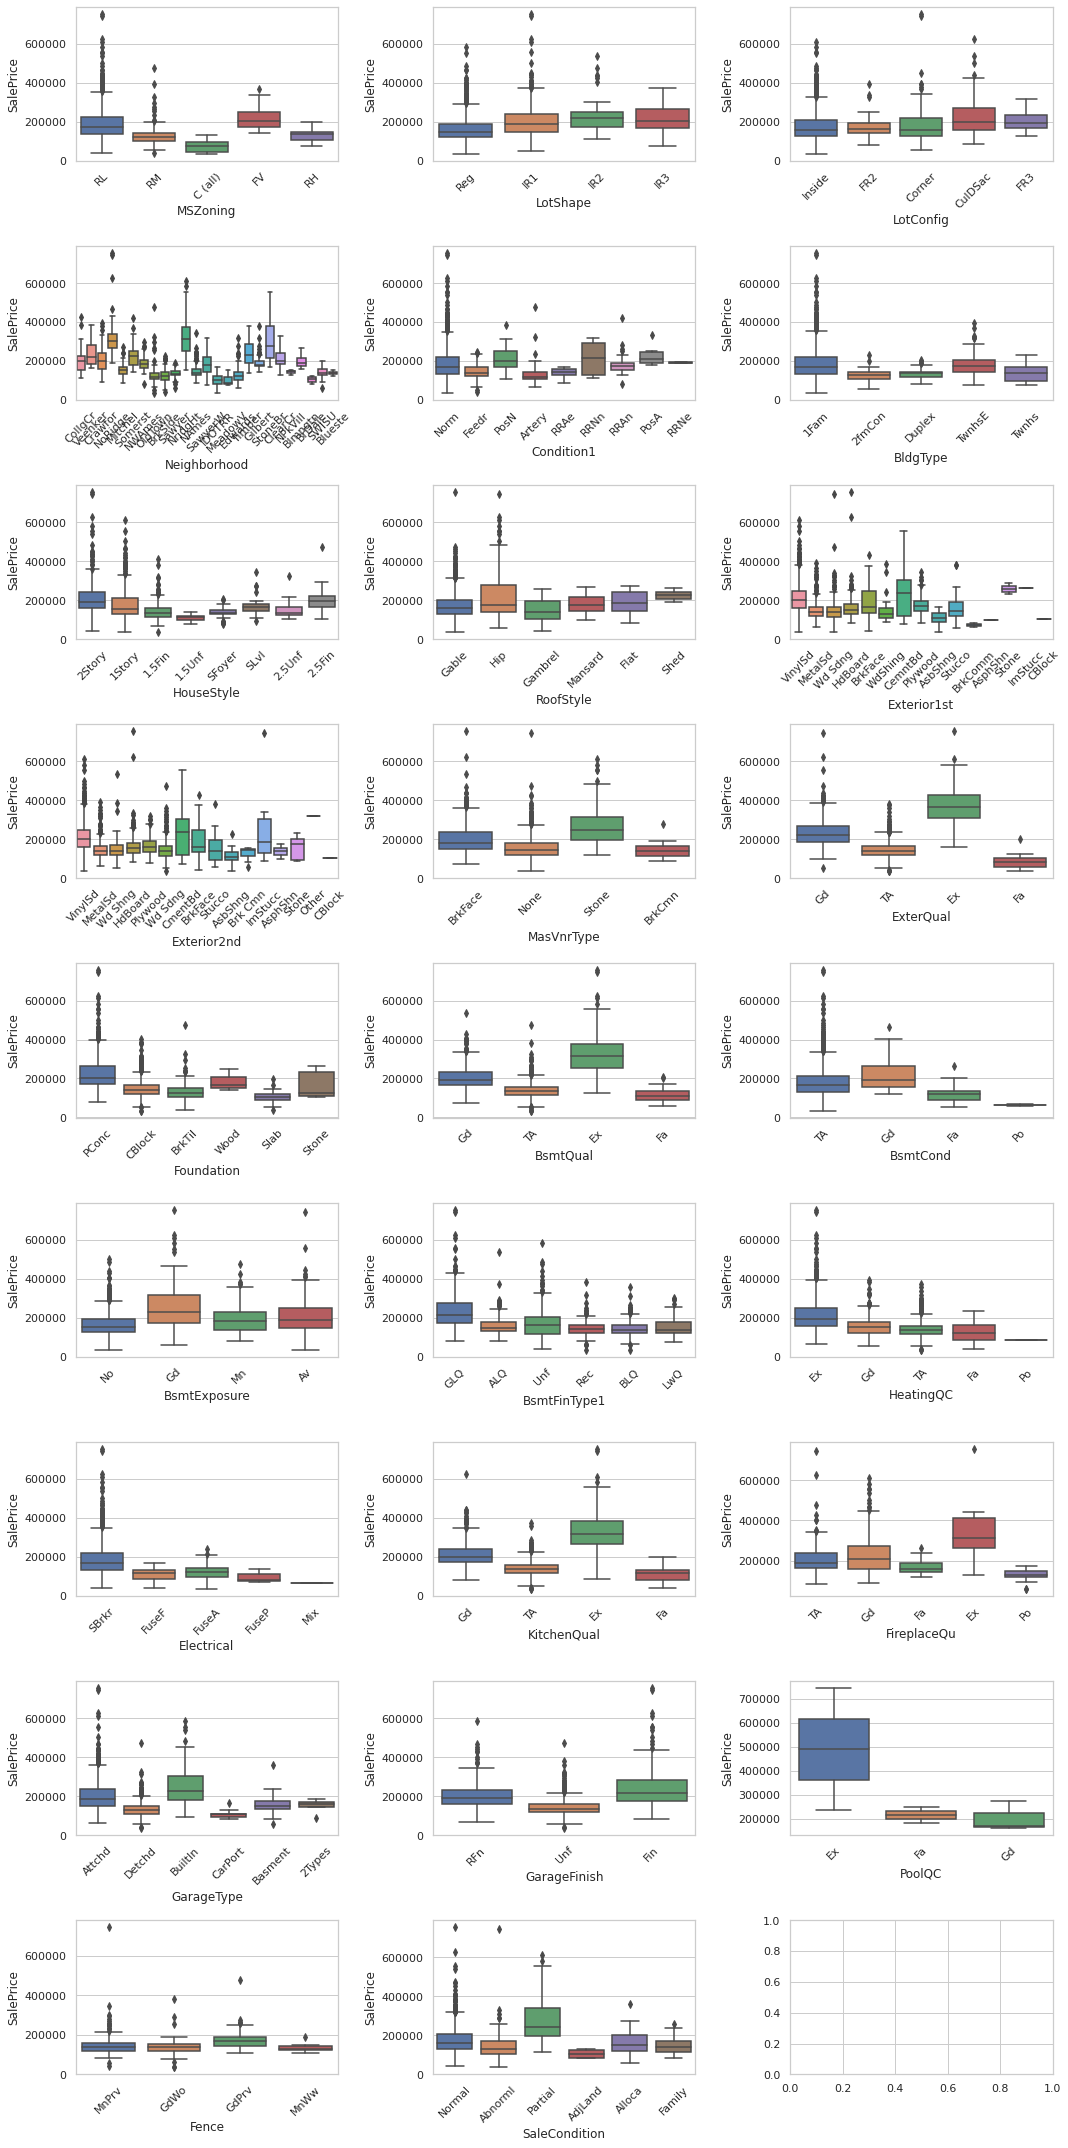

In [25]:
fig, axes = plt.subplots(round(len(df_train_categ.columns)/3), 3, figsize = (15,30))

for i , ax in enumerate(fig.axes):
    # Variación de 'SalePrices' en cada feature categórica
    if i<len(df_train_categ.columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax)

fig.tight_layout()


Algunos de estos features parecen ser codependientes tales como  'Exterior1st' & 'Exterior2nd', 'BsmtQual' & 'BsmtCond', 'MasVnrType' & 'ExterQual' etc. Entonces gráficamos tablas de contigencia, luego veamos el test de Chi cuadrado e identifiquemos éstas codependencias.

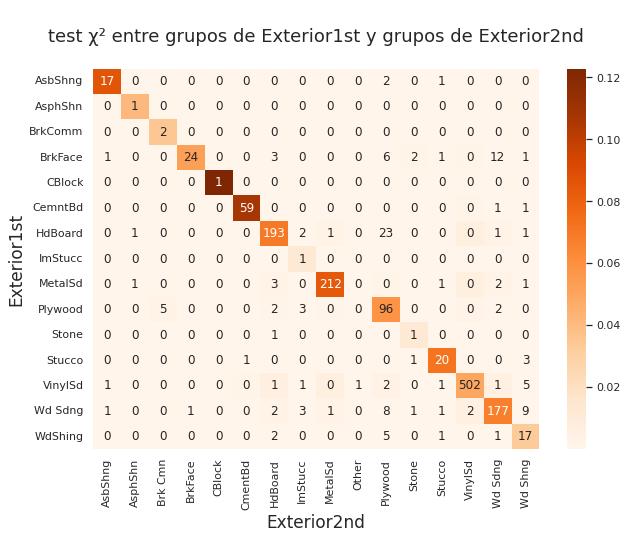

Valor-P del ChiSq Test entre Exterior1st y Exterior2nd es: 0.0



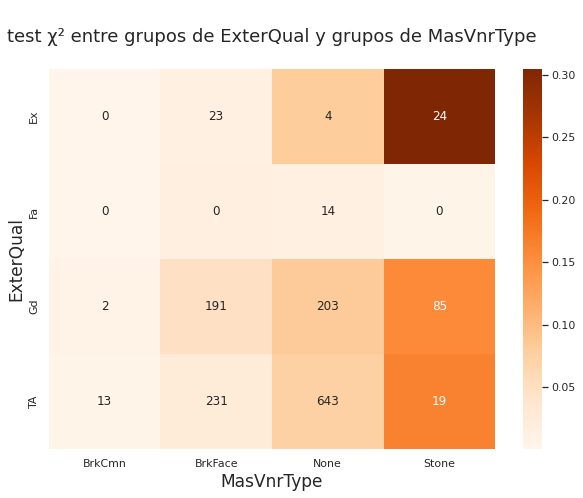

Valor-P del ChiSq Test entre ExterQual y MasVnrType es: 1.0187554679218715e-54



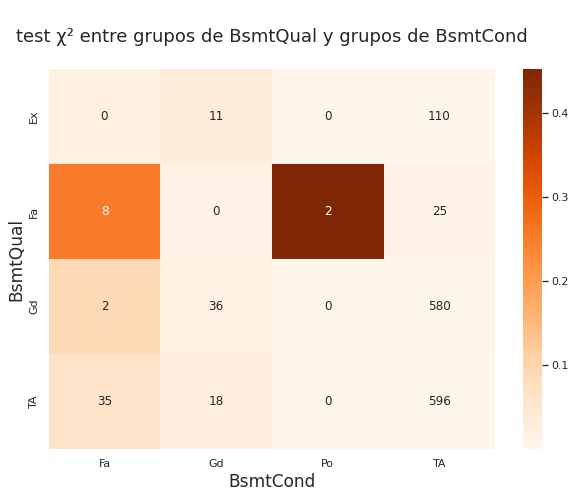

Valor-P del ChiSq Test entre BsmtQual y BsmtCond es: 1.9371809126533347e-31



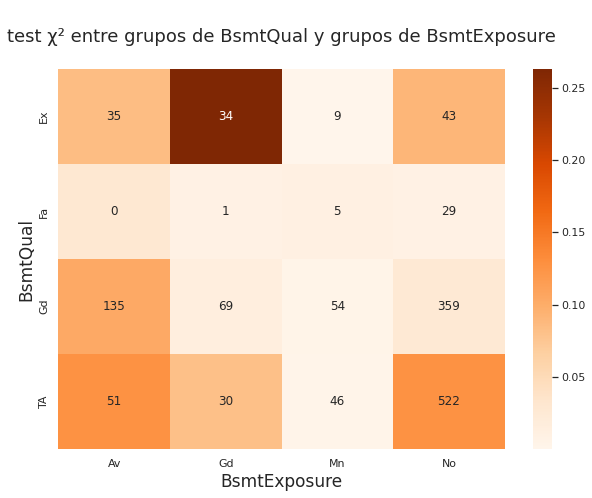

Valor-P del ChiSq Test entre BsmtQual y BsmtExposure es: 3.879215036512606e-32



In [26]:
# Graficamos las tablas de contingencia

# Establecemos en el tamaño de la figura
sns.set(rc={"figure.figsize": (10,7)})

#Definimos las variables
X = ["Exterior1st", "ExterQual", "BsmtQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtCond", "BsmtExposure"]

for i,j  in zip(X,Y):
    # Creamos un pivot table entre las variables
    cont =  df_train_categ[[i,j]].pivot_table(index = i, columns = j, aggfunc = len, margins = True, margins_name="Total")
    
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n=len(df_train_categ)
    indep = tx.dot(ty)/n
    
    c = cont.fillna(0)
    measure = (c-indep)**2/indep
    x1_n = measure.sum().sum()
    table = measure/x1_n
    
    # Graficamos la tabla de contingencia
    p = sns.heatmap(table.iloc[:-1, :-1], annot = c.iloc[:-1,:-1], fmt = ".0f", cmap="Oranges")
    
    p.set_xlabel(j, fontsize = 17)
    p.set_ylabel(i, fontsize = 17)
    p.set_title(f"\ntest χ² entre grupos de {i} y grupos de {j}\n", size=18)
    plt.show()
    
    # Realizamos test Chi square
    CrosstabResult = pd.crosstab(index = df_train_categ[i], columns = df_train_categ[j])
    
    ChiSqResult = chi2_contingency(CrosstabResult)
    
    # P-value es la probabilidad de Ho sea Verdad
    print(f"Valor-P del ChiSq Test entre {i} y {j} es: {ChiSqResult[1]}\n")  

El valor P es significante para todos los test, de modo que hay codependecia entre estas variables. Por ésta razón eliminarremos las features 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' y 'MasVnrType'. 

In [27]:
# Eliminamos cada una de las variables codependientes.
# Eliminamos en el dataset de Train
df_train_categ.drop(Y, axis=1, inplace=True)

# Eliminamos en el dataset de Test
df_test_categ.drop(Y, axis=1, inplace=True)

#### Datos faltantes en features categóricas

Train set

Text(0, 0.5, 'Nombre de Columnas\n')

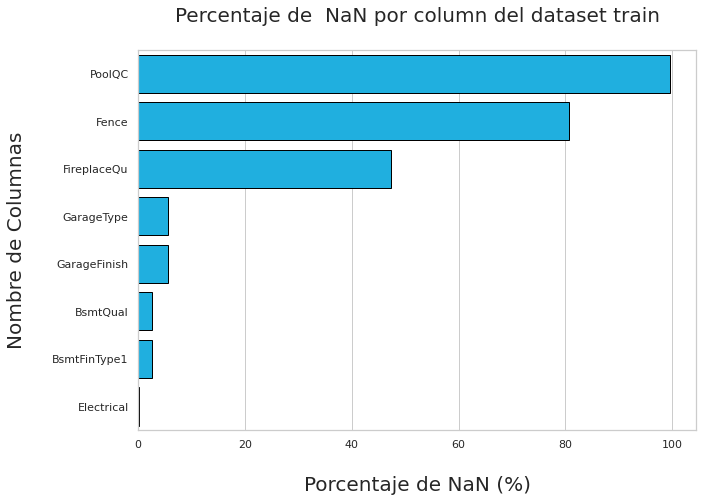

In [28]:
# Chequeamos los NaN del dataset est para graficar el porcentaje de valores faltantes por columna
column_with_nan = df_train_categ.columns[df_train_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df_train_categ[i].isnull().sum()*100/len(df_train_categ), 2))
    
tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by = ["Percent_NaN"], ascending=False, inplace=True)

# Definimos parámetros de figura 
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Graficamos el barplot con los resultados
p = sns.barplot(x= "Percent_NaN",  y = "Column", data = tab,
                edgecolor = "black", color = "deepskyblue")

p.set_title("Percentaje de  NaN por column del dataset train\n", fontsize = 20)
p.set_xlabel("\nPorcentaje de NaN (%)", fontsize = 20)
p.set_ylabel("Nombre de Columnas\n", fontsize=20)   


Se eliminarán las fatures donde el porcentaje de NaN es mayor al 5% para evitar introducir algún error. Es mejor que imputar NaN de  'BsmtQual' y 'Electrical por la correspondiente clase modal. 

In [29]:
# Elimiminamos los features donde el porcentaje de NaN es mayor al 5%
df_train_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish"],axis = 1, inplace=True)

In [30]:
# Llenamos los NaN de cada features para la correspondiente clases modal
categ_fill_null = {"BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_train_categ["Electrical"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

#### Test Set

Las columnas que han sido eliminadas en el dataset train también deben ser eliminadas en el dataset test de modo queambos datasets permanezcan identicos para el modelo y predicción.

In [31]:
# Eliminamos las mismas features del dataset train en el dataset test
df_test_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                    "GarageType", "GarageFinish"], axis = 1, inplace=True)

Text(0, 0.5, 'Nombre de columnas\n')

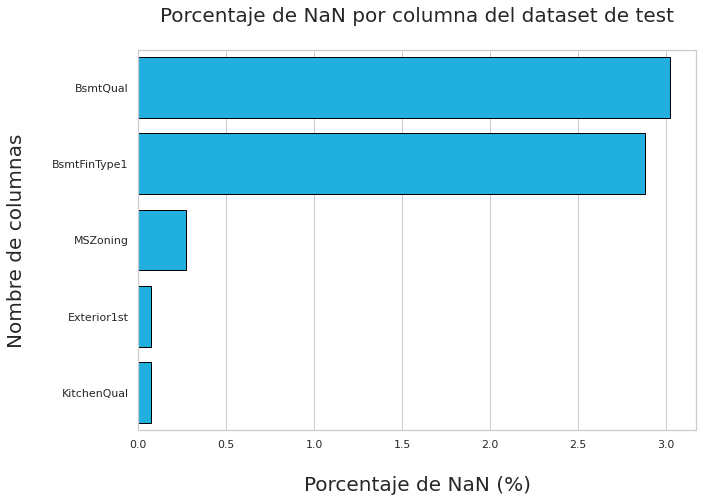

In [32]:
# Chequeamos los NaN del test dataset para graficar el porcentaje de valores faltantes por columna
column_with_nan = df_test_categ.columns[df_test_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df_test_categ[i].isnull().sum()*100/len(df_test_categ), 2))
    
tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by = ["Percent_NaN"], ascending=False, inplace=True)

# Definimos parámetros de figura 
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Graficamos el barplot con los resultados
p = sns.barplot(x= "Percent_NaN",  y = "Column", data = tab,
                edgecolor = "black", color = "deepskyblue")

p.set_title("Porcentaje de NaN por columna del dataset de test\n", fontsize = 20)
p.set_xlabel("\nPorcentaje de NaN (%)", fontsize = 20)
p.set_ylabel("Nombre de columnas\n", fontsize=20)     


Llenamos de NaN cada features que le corresponda a la clase modal

In [33]:
categ_fill_null = {"BsmtQual": df_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_test_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_test_categ["Electrical"].mode().iloc[0]}

df_test_categ = df_test_categ.fillna(value=categ_fill_null)

### Transformación de features categóricas en features binarias (get dummies)

**Train set**

In [34]:
# dataset de entrenamiento (Train)
for i in df_train_categ.columns.tolist()[:-1]:
    df_dummies = pd.get_dummies(df_train_categ[i], prefix = i)
    
    # Fusionamos amba tablas
    df_train_categ =df_train_categ.join(df_dummies)
    
# Seleccionamos las features binarias solamente
df_train_binary = df_train_categ.iloc[:, 18:]
df_train_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


**Test
set**

In [35]:
# dataset de entrenamiento (Train)
for i in df_test_categ.columns.tolist():
    df_dummies = pd.get_dummies(df_test_categ[i], prefix=i)
    
    # Fusionamos amba tablas
    df_test_categ =df_test_categ.join(df_dummies)
    
# Seleccionamos las features binarias solamente
df_test_binary = df_test_categ.iloc[:, 17:]
df_test_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


Podemos observar que df_test_binary hay 118 columnas mientras que en df_train_binary hay 122 columnas. Veamos que columnas son extrañas a partir de df_test_binary

In [36]:
# Revisemos si los encabezados de columnas en ambos dataset: df_train y df_test
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
        f"Features presentes in df_train_categ y ausentes en df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
        f"Features presentes in df_test_categ y ausentes en df_train_categ: {dif_2}\n")

Features presentes in df_train_categ y ausentes en df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix']

Features presentes in df_test_categ y ausentes en df_train_categ: []



Cuatro de las features binarias en el dataset de test. Por lo tanto estas features serán eliminadas del dataset de train para tener el mismo número de features en ambos datasets

In [37]:
# Eliminamos estas colunas del dataframe df_train_binary
df_train_binary.drop(dif_1, axis =1, inplace=True)

# Revisamos otra vex si los encabezamods de columna son los mismo en ambos datasets
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
        f"Features presentes in df_train_categ y ausentes en df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
        f"Features presentes in df_test_categ y ausentes en df_train_categ: {dif_2}\n")

Features presentes in df_train_categ y ausentes en df_test_categ: []

Features presentes in df_test_categ y ausentes en df_train_categ: []



Ambos dataset tienen el mismo número de features ahora.

### 1.4 Fusión de features numéricas y binarias en un solo conjunto de datos

Vamos añadir features binarias a features numéricas

In [38]:
# Train set
df_train_new = df_train_imputed.join(df_train_binary)
print(f"Train set: {df_train_new.shape}")

# Test set
df_test_new = df_test_imputed.join(df_test_binary)
print(f"Test set: {df_test_new.shape}")

Train set: (1460, 135)
Test set: (1459, 134)


### 1.5 Eliminado outliers desde el train set.

Previamente en la parte **1.2 Features Numéricas** de este notebook, se observo algunas casas con gran superficie ("GrLivArea", "TotalBsmtSF" y "GarageArea") y precios muy bajos. Es mejor para nuestro modelo eliminar estos outliers.

También se observo que ambos features "WoodDeckSF" y "OpenPorchSF" tienen un alto número de valores 0 con una variación de precio correspondientemente alta. Estos outliers deberían ser borradas. Sin embargo,ya que el número de outliers es muy importante, lo mejor es eliminar estas columnas.  

In [39]:
# Eliminamos "WoodDeckSF" y "OpenPorchSF"
df_train_new.drop(["WoodDeckSF", "OpenPorchSF"], axis = 1, inplace=True)
df_test_new.drop(["WoodDeckSF", "OpenPorchSF"], axis = 1, inplace=True)

In [40]:
# Manejamos los outliers en "GrLivArea", "TotalBsmtSF" y "GarageArea"
# Outliers en "GrLivArea"
outliers1 = df_train_new[(df_train_new["GrLivArea"] > 4000) & (
                        df_train_new["SalePrice"] <= 200000)].index.tolist()
# Outliers en "TotalBsmtSF"
outliers2 = df_train_new[(df_train_new["TotalBsmtSF"]>3000) & (
                        df_train_new["SalePrice"] <= 400000)].index.tolist()
#Outliers en "GarageArea"
outliers3 = df_train_new[(df_train_new["GarageArea"]>1200) & (
                        df_train_new["SalePrice"] <= 300000)].index.tolist()
# Lista de todos los outliers
outliers = outliers1 + outliers2 + outliers3
outliers = list(set(outliers))
print(outliers)

# Eliminamos estos outliers
df_train_new = df_train_new.drop(df_train_new.index[outliers])

# Reseteaos el index
df_train_new = df_train_new.reset_index().drop("index", axis = 1)

[1061, 581, 1190, 523, 332, 1298]


# 2. Ingeniería de caracteristicas

Mientras se observa de cerca las características restantes, podemos observar que varios de ellos designan una determinada superficie de la propiedad. Por lo tanto se intentará combinar algunas de estas superficies dentro de indicadores sin perder información que ellos proveen.

Además se convirtirá años en edad. Por ejemplo. Los años de construcción serán transformados en edad de la casa desde la construcción. 

In [41]:
# Definimos una función para calcular la tasa de ocupación del primer piso del área total.
def floor_occupation(x):
    """ Ocupación del primer piso del area habitable total
        
        La ecuación de floor_ocupation tiene la siguente forma:
        (Area_1er_priso*100)/(Area_habitable_del_suelo)
        
        Argumentos: 
            x -- la característica correspondiente
            
        Returna:
            0 -- Si el Area_habitable_del_suelo = 0
            ecuación -- Area_habitable_del_suelo> 0"""
    if x["GrLivArea"] == 0:
        return 0
    else:
        return x['1stFlrSF']*100/x["GrLivArea"]

# Aplicamos la función sobre el dataset de train y test
df_train_new['1stFlrPercent'] = df_train_new.apply(
                                lambda x: floor_occupation(x), axis = 1)

df_test_new['1stFlrPercent'] = df_test_new.apply(
                                lambda x: floor_occupation(x), axis = 1)

# Eliminamos "1stFlrSF" y "2ndFlrSF"
df_train_new.drop(["1stFlrSF" , "2ndFlrSF"], axis = 1, inplace=True)
df_test_new.drop(["1stFlrSF" , "2ndFlrSF"], axis = 1, inplace=True)

In [42]:
# Definimos una función para calcular el área del sótano terminado

def bsmt_finish(x):
    """ Proporción del área terminada en sótano
    
    la ecuación de bsmt_finish tiene la siguiente forma:
    (Área terminada de sótano*100)/(Área total del sótamo)
    
    Argumentos:
        x -- la feature correspondiente
        
    Retorna:
        0 -- Si el Área total del sótano = 0
        ecuación -- Si el Área total del sótano > 0 
    """
    if x["TotalBsmtSF"] == 0:
        return 0
    else:
        return x["BsmtFinSF1"]*100 / x["TotalBsmtSF"]

# Aplicamos la función sobre el dataset de train y test
df_train_new['BsmtFinPercent'] = df_train_new.apply(
                                lambda x: bsmt_finish(x), axis = 1)

df_test_new['BsmtFinPercent'] = df_test_new.apply(
                                lambda x: bsmt_finish(x), axis = 1)

# Eliminamos "BsmtFinSF1"
df_train_new.drop(["BsmtFinSF1"], axis = 1, inplace=True)
df_test_new.drop(["BsmtFinSF1"], axis = 1, inplace=True)


In [43]:
# Convertimos Año de construcción a edad de la casa desde la construcción
df_train_new['AgeSinceConst'] = ( 
        df_train_new["YearBuilt"].max() - df_train_new["YearBuilt"])

df_test_new['AgeSinceConst'] = ( 
        df_test_new["YearBuilt"].max() - df_test_new["YearBuilt"])

# Eliminamos "YearBuilt"
df_train_new.drop(['YearBuilt'], axis = 1, inplace=True)
df_test_new.drop(['YearBuilt'], axis = 1, inplace=True)

In [44]:
# Convertimos el año de remodelación a edad de la casa desde la remodelación
df_train_new['AgeSinceRemod'] = ( 
        df_train_new["YearRemodAdd"].max() - df_train_new["YearRemodAdd"])

df_test_new['AgeSinceRemod'] = ( 
        df_test_new["YearRemodAdd"].max() - df_test_new["YearRemodAdd"])

# Eliminamos "YearRemodAdd"
df_train_new.drop(['YearRemodAdd'], axis = 1, inplace=True)
df_test_new.drop(['YearRemodAdd'], axis = 1, inplace=True)

Para evitar redundancia y mitigar variacines fuertes de algunas features según el SalePrice. Usaremos una transformación para features cezgadas o asimétricas.Generalmente en bienes raíces, a medida que aumenta el área de la propiedad, el precio por pie cuadrado disminuye, de ahí el uso de log.

In [45]:
continous_features = ["OverallQual", "TotalBsmtSF", "GrLivArea",
                       "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea",
                       "MasVnrArea", "Fireplaces", "1stFlrPercent",
                       "BsmtFinPercent", "AgeSinceConst", "AgeSinceRemod"]
df_skew_verify = df_train_new.loc[:, continous_features]

In [46]:
# Seleccionamos características con un skew absoluto igual mayor a 0.5
skew_ft = []

for i in continous_features:
    # Enlistar un valor de skew por cada feature correspondiente
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed  = pd.DataFrame({"Columns": continous_features,
                          "Abs_skew": skew_ft})

sk_features = df_skewed[df_skewed["Abs_skew"]> 0.5]["Columns"].tolist()
print(f"lista de features sezgadas: {sk_features}")

lista de features sezgadas: ['GrLivArea', 'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'AgeSinceConst', 'AgeSinceRemod']


Aplicar una transformación log a una feautures con sezgo de valor grande permite reducir el grado de sezgo, por lo que se aplicará esta transformada a cada una de las features dentro de la lista.

In [47]:
# Transformación Log de features sezgadas

for i in sk_features:
    # Genramos ciclos sobre i (cada features) para calcular log de la superficies
    # Train set
    df_train_new[i] = np.log((df_train_new[i])+1)
    
    # Test set
    df_test_new[i] = np.log((df_test_new[i])+1)    


# 3. Preparando los datos para el modelamiento

## 3.1 Variable Target: SalePrice

Se aplica la transformación log de la variable independiente ('SalePrice') para tener una distribución que se aproxime a la distribución normal

Text(0, 0.5, '')

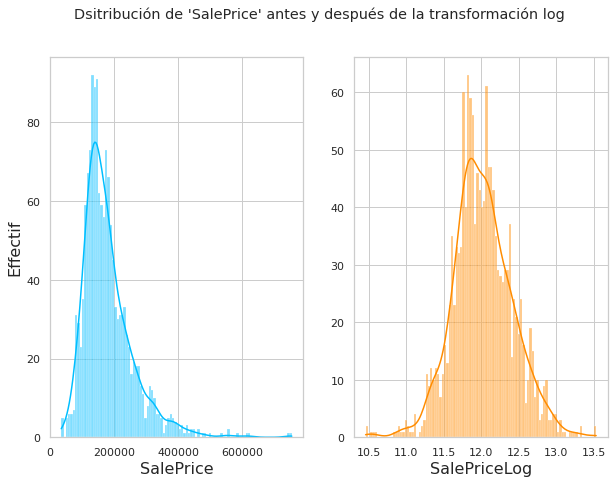

In [48]:
# Transformación log de la variable objetivo "SalePrice"
df_train_new["SalePriceLog"] = np.log(df_train_new.SalePrice)

# Grafica de distribución antes y después de la transformación
fig, axes = plt.subplots(1,2)
fig.suptitle("Dsitribución de 'SalePrice' antes y después de la transformación log")

# Antes de la transformación log
p  = sns.histplot(ax = axes[0], x = df_train_new["SalePrice"], kde = True, bins = 100, color = "deepskyblue")

p.set_xlabel("SalePrice", fontsize = 16)
p.set_ylabel("Effectif", fontsize = 16)

# Después de la transformación
q  = sns.histplot(ax = axes[1], x = df_train_new["SalePriceLog"], kde = True, bins = 100, color = "darkorange")

q.set_xlabel("SalePriceLog", fontsize = 16)
q.set_ylabel("", fontsize = 16)

In [49]:
# Eliminamos el 'SalePrice' original
df_train_new.drop(['SalePrice'], axis = 1, inplace=True)

## 3.2 Dividir datos dentro del dataset train y set y standarizarlos

In [50]:
# Extraer los features (X),  y el target (y)
# Features (X)
X = df_train_new[[i for i in list(
                    df_train_new.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)
y = df_train_new.loc[:, "SalePriceLog"]
print(y.shape)

(1454, 131)
(1454,)


In [51]:
# Dividir datos dentro de X_train y X_test (para estratificar y)
# Estratificar sobre una variable continua dividiendolo en bins
# Creamos los bins
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Dividimos los datos (80% para train, 20% para test) usando la funcion train_set_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   stratify = y_binned, shuffle=True)

print(f"X_train:{X_train.shape}\ny_train: {y_train.shape}")
print(f"X_test:{X_test.shape}\ny_test: {y_test.shape}")

X_train:(1163, 131)
y_train: (1163,)
X_test:(291, 131)
y_test: (291,)


#### Estandarizamos los datos

In [52]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# La misma estandarización es aplicada para df_test_new
df_test_new = std_scale.transform(df_test_new)


# La salida de la estandatización. Cambiemosle a una tabla.
# Convetir X, y y datos de test en un dataframe
X_train= pd.DataFrame(X_train, columns = X.columns)
X_test= pd.DataFrame(X_test, columns = X.columns)
df_test_new =  pd.DataFrame(df_test_new, columns = X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

## 3.3 Regresión escalonada hacia atrás (Backward Stepwise Regression)

Aligeremos el modelo con una regresión escalonada hacia atrás.

La regresión escalonada hacia atrás es un enfoque de regresión por pasos que comienza con un modelo completo (saturado) y en cada paso elimina gradualmente las variables del modelo de regresión para encontrar un modelo reducido que explique mejor los datos. También conocida como regresión de eliminación hacia atras.

In [53]:
Selected_Feautures = []

def backward_regression(X, y, initial_list=[], threshold=0.01, threshold_out=0.05, verbose = True ):
    """Seleccionar features con Regressión escalonada hacia atrás
    
    Args:
        X -- valores de features
        y -- variable target
        
        initial_list -- encabezado de features
        threshold_in -- umbral de  valor-p de features a mantener
        threshold_out -- umbral de  valor-p de features a eliminar
        verbose -- true para prudcir una cantidad de resultados de regsitro
    
    Returns:
        Lista de features seleccionadas para el modelo
           
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        
        # Usar todos los coeficientes excepto interceptar
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null si p_value esta vacío
        if worst_pval > threshold_out:
            changed = True
            worst_features = pvalues.idxmax()
            included.remove(worst_features)
            if verbose:
                print(f"worst_feature: {worst_features}, {worst_pval}")
            
        if not changed:
            break
    Selected_Feautures.append(included)
    print(f"\nFeatures Seleccionadas:\n{Selected_Feautures}")
    
# Aplicamos la regresión escalomada hacia atrás sobre nuestro datos
backward_regression(X_train, y_train)     
        
        

worst_feature: Foundation_PConc, 0.9797243578303991
worst_feature: Exterior1st_WdShing, 0.9780512946479527
worst_feature: Neighborhood_CollgCr, 0.9704987344380159
worst_feature: Neighborhood_Timber, 0.9491947660965094
worst_feature: Neighborhood_Blueste, 0.9475000762316133
worst_feature: Condition1_PosN, 0.946484294141424
worst_feature: Exterior1st_AsphShn, 0.9429532297258225
worst_feature: BsmtFinType1_Rec, 0.9296526925245435
worst_feature: HouseStyle_SFoyer, 0.9268470139359634
worst_feature: Exterior1st_Stucco, 0.9233289197007718
worst_feature: Exterior1st_VinylSd, 0.9265220351990111
worst_feature: BldgType_2fmCon, 0.926482215826191
worst_feature: RoofStyle_Hip, 0.90281749423496
worst_feature: Condition1_RRNn, 0.9011020741820827
worst_feature: Neighborhood_Sawyer, 0.9005646384386468
worst_feature: ExterQual_TA, 0.8684523974093898
worst_feature: LotShape_IR1, 0.8271478159640899
worst_feature: Condition1_RRAn, 0.8230058730685801
worst_feature: ExterQual_Fa, 0.8216092174772928
worst_fea

In [54]:
# Mantenemos las feutures seleccionadas solamente
X_train = X_train.loc[:, Selected_Feautures[0]]
X_test = X_test.loc[:, Selected_Feautures[0]]
df_test_new = df_test_new.loc[:, Selected_Feautures[0]]

## 3.4 Factor de inflación de varianza

El factor de inflación de varianza (VIF), es una medida de la cantidad de Multicolinealidad en un conjunto de variables de regression múltiple. Matemáticamente, el VIF para una variable de regresión es igual a la relación entre varianza general del modelo y la varianza de un modelo que incluya solo esa única variable independiente. 

Una feature con una VIF alta mayor que 10 implica que hay una multicolinealidad con éste último

In [55]:
# Calculamo el VIF para cada feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Resultados VIF en una tabla
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,3.40,OverallQual
1,3.10,TotalBsmtSF
2,3.60,GrLivArea
3,5.70,GarageCars
4,5.50,GarageArea
5,1.50,Fireplaces
6,inf,MSZoning_C (all)
7,inf,MSZoning_FV
8,inf,MSZoning_RH
9,inf,MSZoning_RL


In [56]:
# Seleccinamos los features con más alta VIF
hight_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()

if len(hight_vif_list) == 0:
    # Se imprime una lista vacía si hay una multicolinealidad baja
    print(f"Ninguna de las features tiene una alta multicolinealidad")
else:
    # Se imprime una lista de features con alta colinealidad
    print(f"Lista de features con alta colinealidad: {hight_vif_list}")

Lista de features con alta colinealidad: ['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_SBrkr']


La fuerte colinealidad es probablemente debido a la presencia de bastantes ceros en éstas features binarias. Estas features binarias deben ser borradas.

In [57]:
# Eliminamos las features con alta multicolinealidad de X_train, X_test y df_test_new
X_train.drop(hight_vif_list, axis = 1, inplace=True)
X_test.drop(hight_vif_list, axis = 1, inplace=True)
df_test_new.drop(hight_vif_list, axis = 1, inplace=True)

## 3.5 Distancia de Cook

Para calcular la distancia de Cook podemos detectar las observaciones influyentes. La distancia de Cook detecta datos con grandes residuos (outliers) que pueden distorcionar la predicción y la presición de la regresión. 

In [58]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Distancia de Cook
np.set_printoptions(suppress=True)

# Creamos una instancia de influencia
influence = lr.get_influence()

# Obtenemos la distancia de Cook para cada observación
cooks = influence.cooks_distance

# Definimos el resultado en un DataFrame
cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.sample(5)

,Cook_Distance,p_value
44,0.00,1.00
1133,0.00,1.00
1049,0.00,1.00
355,0.00,1.00
89,0.01,1.00


In [59]:
# Removemos las observaciones influyentes de X_train y_train
influent_observation = cook_df[cook_df['p_value']<0.5].index.tolist()
print(f"Observaciones influyentes eliminadas: {influent_observation}")

# Eliminamos estas observaciones
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])


Observaciones influyentes eliminadas: []


# 4. Modelado

## 4.1 Selección de modelos y métricas

Aquí vamos a usar métricas RMSE y R² para medir el rendimiento de los modeos seleccionados y sus predicciones.

Entonces probaremos los modelos que mejor cumplan las estimaciones del precio de las Viviensas. Usaremos los siguientes modelos:

* Regresión de Ridge
* Regreseión de Lasso
* Regresión de red elástica
* Regresión de soporte de vector (SVR)
* Regresión de bosque aleatorio
* XGBoost
* LigthGBM

In [60]:
# Importamos librerías necesarias
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [61]:
# Definamos una función para cada metrica
# R²

def rsqr_score(test, pred):
    """Calcular el valor de R Cuadrado
    
    Args:
        test -- test de datos
        pred -- perdicción de datos
        
    Returns:
        valor de R Cuadrado
    """
    
    r2_ = r2_score(test, pred)
    return r2_

# RMSE
def rmse_score(test, pred):
    """ Calcular la Raiz del Error Cuadrático Medio
    
    Args:
        test -- test de datos
        pred -- predicción de datos
        
    Returns:
        Raíz del Error Cuadrático Medio    
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_

# Imprimir los resultados
def print_score(test, pred):
    """ Imprimir resultados
    
    Args:
        test -- test de datos
        pred -- predicción de datos
        
    Returns:
        imprimir el nombre de la regresión
        imprimir valor de R cuadrado 
        imprimir valor de la Raíz del Error Cuadrático Medio (RMSE)
    """
    print(f"- Regresor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

#### Definimos los modelos de Regresión

In [62]:
ridge = Ridge()
lasso = Lasso(alpha=0.001)
elastic = ElasticNet(alpha=0.001)
svr = SVR()
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Entrenamos los modelos sobre X_train y y_train
for regr in [ridge, lasso, elastic, svr, rdf, xgboost, lgbm]:
    # Ajustamos al modelo correspondiente
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    # Imprimimos las métricas definidas arriba para cada clasificador
    print_score(y_test, y_pred)

- Regresor: Ridge
R²: 0.8845111479046254
RMSE: 0.13326178066945074

- Regresor: Lasso
R²: 0.8870331618663417
RMSE: 0.13179868173267417

- Regresor: ElasticNet
R²: 0.8858478699565101
RMSE: 0.13248831892870389

- Regresor: SVR
R²: 0.8449552614199587
RMSE: 0.15440597294616892

- Regresor: RandomForestRegressor
R²: 0.8785000152321316
RMSE: 0.13668589206698514

- Regresor: XGBRegressor
R²: 0.8656878379095023
RMSE: 0.14371207163506955

- Regresor: LGBMRegressor
R²: 0.8761636412816924
RMSE: 0.13799382934114426



De acuerdo al resultado de R² y RMSE de estos siete modelos concluimos que las relaciones entre las features y la variable target es claramente lineal. Por lo tanto en la siguiente parte se optimizará los hiperparámetros para todos lo modelos excepto SVR.

De echo, SVR reconoce la presencia de no linealidad en los datos y proporciona un modelo de predicción competente. La idea detrás de SVR es encontrar la mejor línea ajustada la cual es un hiperplano que tiene un número máximo de puntos. Esta claro que nuestro modelo es lineal y eso es por que no se optimizó el modelo de SVR.

## 4.2 Ajuste de hiperparámetros y optimización del modelo.

### Regresión Ridge

Ridge reducirá el impacto de las features que no son importantes en la predicción de los valores del Target.

In [63]:
from sklearn.model_selection import GridSearchCV

# Definimos los hiperparámetros 
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# Ajuste de GridSearch sobre el dataset de entrenamiento
ridge_cv.fit(X_train, y_train)

# Imprimir los mejores parámetros y el R² correspondiente
print(f"Los mejores hiperparámetros: {ridge_cv.best_params_}")
print(f"El mejor R²: {ridge_cv.best_score_}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Los mejores hiperparámetros: {'alpha': 33.9322177189533}
El mejor R²: 0.8932618966365091


In [64]:
# Regresión de Ridge con el mejor hiperparámetro
ridge_mod = Ridge(alpha=ridge_cv.best_params_["alpha"])

# Ajustamos el modeo sobre el dataset de entranamiento
ridge_mod.fit(X_train, y_train)

# Predicciones usando el dataset de pruebas
y_pred = ridge_mod.predict(X_test)

print(f"- {ridge_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- Ridge
R²: 0.8852101818372652
RMSE: 0.13285786334256014


In [65]:
# Guardamos los resultados del modelo dentro de listas
model_list = []
r2_list = []
rmse_list = []

model_list.append(ridge_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

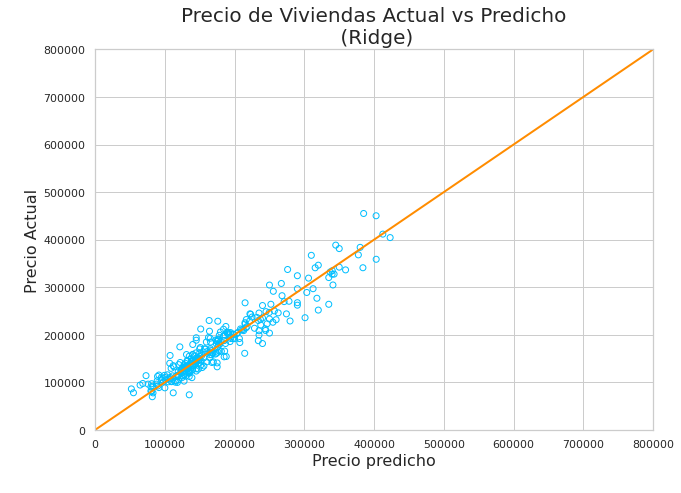

In [66]:
# Gráfica actual vs Predicción de Precio de Viviendas
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Precio de Viviendas Actual vs Predicho\n (Ridge)", fontsize = 20)
plt.scatter(actual_price, predicted_price, 
           color = "deepskyblue", marker = 'o', facecolors= "none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0,800000)
plt.ylim(0,800000)
plt.ylabel("\nPrecio Actual", fontsize=16)
plt.xlabel("Precio predicho\n", fontsize=16)
plt.show()


El modeo es capaz de predecir los precios de las viviendas, sin embargo sobreestima el precio de la casas que están por encima del 400000 dolares.

#### Regresión de Lasso

Lasso eliminará muchas features y reducirá el overfitting (sobreajuste) en el modelo lineal.

In [67]:
# Definimos los hiperparámetros
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
lasso_cv = GridSearchCV(Lasso(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# Ajuste de GridSearch sobre el dataset de entrenamiento
lasso_cv.fit(X_train, y_train)

# Imprimir los mejores parámetros y el R² correspondiente
print(f"Los mejores hiperparámetros: {lasso_cv.best_params_}")
print(f"El mejor R²: {lasso_cv.best_score_}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Los mejores hiperparámetros: {'alpha': 0.0002682695795279727}
El mejor R²: 0.8928484435473013


In [68]:
# Regresión de Lasso con el mejor hiperparámetro
lasso_mod = Lasso(alpha=lasso_cv.best_params_["alpha"])

# Ajustamos el modeo sobre el dataset de entranamiento
lasso_mod.fit(X_train, y_train)

# Predicciones usando el dataset de pruebas
y_pred = lasso_mod.predict(X_test)

print(f"- {lasso_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- Lasso
R²: 0.885225385477296
RMSE: 0.13284906469626118


In [69]:
# Guardamos los resultados del modelo dentro de listas
model_list.append(lasso_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

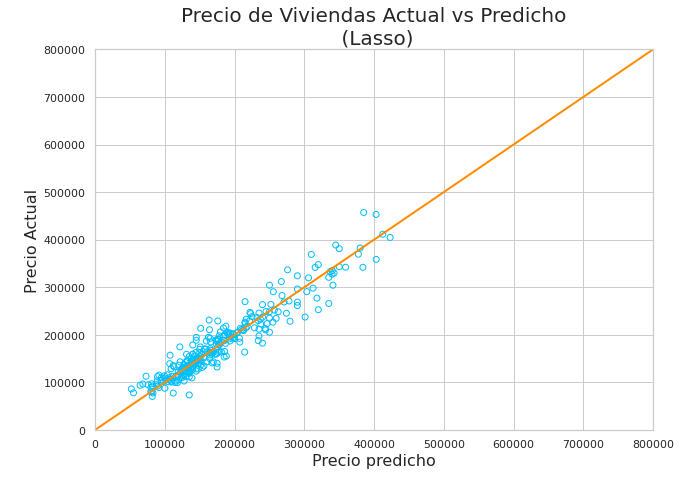

In [70]:
# Gráfica actual vs Predicción de Precio de Viviendas
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Precio de Viviendas Actual vs Predicho\n (Lasso)", fontsize = 20)
plt.scatter(actual_price, predicted_price, 
           color = "deepskyblue", marker = 'o', facecolors= "none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0,800000)
plt.ylim(0,800000)
plt.ylabel("\nPrecio Actual", fontsize=16)
plt.xlabel("Precio predicho\n", fontsize=16)
plt.show()

#### Regresión de XGBoost

XGBoost es un de los algoritmos más populares que se basan en el Gradient Boosted Machines (máquinas impulsadas por gradiente). Gradient Boosting se refiere a la metodolgía donde un conjunto de estudiantes débiles suelen mejorar el rendimiento del modelo e términos de eficiencia, presición, e interoperabilidad. Gradient Boosting puede ser aplicado a la regresión tomando el promedio de las salidas de los aprendiz débiles.

In [71]:
# Definimos los hiperparámetros
tuned_parameters = {"max_depth": [3],
                   "colsample_bytree": [0.3, 0.7],
                   "learning_rate":[0.01, 0.05, 0.1] ,
                   "n_estimators":[100, 500] }

# GridSearch
xgbr_cv = GridSearchCV(estimator = XGBRegressor(), 
                       param_grid=tuned_parameters, 
                       cv=5, 
                       n_jobs=-1, 
                       verbose=1)

# Ajuste de GridSearch sobre el dataset de entrenamiento
xgbr_cv.fit(X_train, y_train)

# Imprimir los mejores parámetros y el R² correspondiente
print(f"Los mejores hiperparámetros: {xgbr_cv.best_params_}")
print(f"El mejor R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Los mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
El mejor R²: 0.8832441192360723


Es mejor establecer más hiperparámetros con más validación cruzada pero consume mucho tiempo. Por lo tanto se limito el ajuste a 3 hiperparámetros con 5 validaciones cruzadas solamente. 

In [72]:
# Regresión de Lasso con el mejor hiperparámetro
xgbr_mod = XGBRegressor(seed=20, 
                        colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
                        learning_rate=xgbr_cv.best_params_['learning_rate'],
                        max_depth = xgbr_cv.best_params_['max_depth'],
                        n_estimators = xgbr_cv.best_params_['n_estimators'])

# Ajustamos el modeo sobre el dataset de entranamiento
xgbr_mod.fit(X_train, y_train)

# Predicciones usando el dataset de pruebas
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.8754291068246671
RMSE: 0.13840247895681873


In [73]:
# Guardamos los resultados del modelo dentro de listas
model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

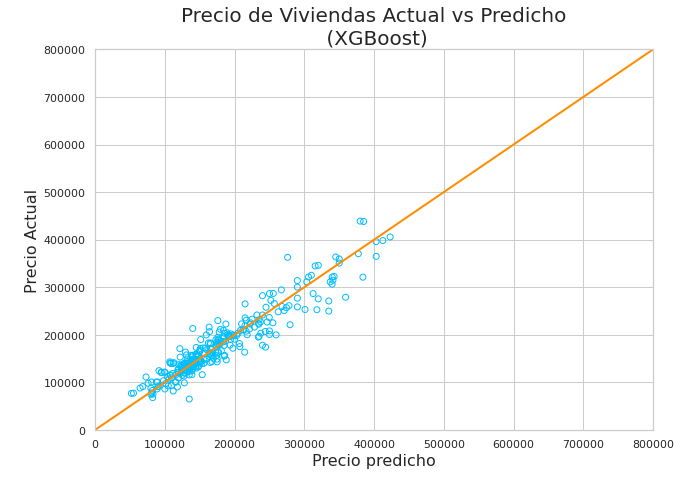

In [74]:
# Gráfica actual vs Predicción de Precio de Viviendas
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Precio de Viviendas Actual vs Predicho\n (XGBoost)", fontsize = 20)
plt.scatter(actual_price, predicted_price, 
           color = "deepskyblue", marker = 'o', facecolors= "none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0,800000)
plt.ylim(0,800000)
plt.ylabel("\nPrecio Actual", fontsize=16)
plt.xlabel("Precio predicho\n", fontsize=16)
plt.show()

#### Regresión de LightGBM 

LigthGBM es también uno de los algoritmos más populares basados en Gradiente Boosted Machines.

In [82]:
# Definimos los hiperparámetros
tuned_parameters = {"max_depth": [3, 6, 10], "learning_rate": [
    0.01, 0.05, 0.1], "n_estimators": [100, 500, 1000], }

# GridSearch
lgbm_cv = GridSearchCV(estimator=LGBMRegressor(), param_grid=tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# Ajuste de GridSearch sobre el dataset de entrenamiento
lgbm_cv.fit(X_train, y_train)

# Imprimir los mejores parámetros y el R² correspondiente
print(f"Best hyperparameters: {lgbm_cv.best_params_}\n")
print(f"Best R²: {lgbm_cv.best_score_}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8814345956096054


In [84]:
# Regresión de LGBM con los mejores hiperparámetros
lgbm_mod = LGBMRegressor(learning_rate=lgbm_cv.best_params_['learning_rate'],
                        max_depth = lgbm_cv.best_params_['max_depth'],
                        n_estimators = lgbm_cv.best_params_['n_estimators'])

# Ajustamos el modeo sobre el dataset de entranamiento
lgbm_mod.fit(X_train, y_train)

# Predicciones usando el dataset de pruebas
y_pred = lgbm_mod.predict(X_test)

print(f"- {lgbm_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- LGBMRegressor
R²: 0.8812531430609093
RMSE: 0.13512840214887617


In [85]:
# Guardamos los resultados del modelo dentro de listas
model_list.append(lgbm_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

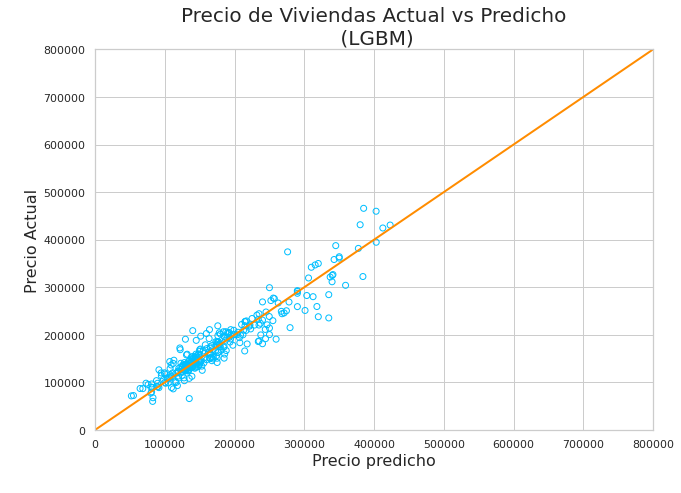

In [87]:
# Gráfica actual vs Predicción de Precio de Viviendas
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Precio de Viviendas Actual vs Predicho\n (LGBM)", fontsize = 20)
plt.scatter(actual_price, predicted_price, 
           color = "deepskyblue", marker = 'o', facecolors= "none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0,800000)
plt.ylim(0,800000)
plt.ylabel("\nPrecio Actual", fontsize=16)
plt.xlabel("Precio predicho\n", fontsize=16)
plt.show()

## 4.3 Eligiendo el mmejor modelo

In [89]:
# Creamos una tabla tipo Dataframe
model_results = pd.DataFrame({"Modelo": model_list,
                              "R²": r2_list,
                              "RMSE": rmse_list})
model_results

,Modelo,R²,RMSE
0,Ridge,0.89,0.13
1,Lasso,0.89,0.13
2,XGBRegressor,0.88,0.14
3,LGBMRegressor,0.88,0.14


Los resultados muestran que el mejor rendimiento en términos R cuadrado (R²) y Raíz del Error Cuadrático Medio (RMSE) corresponde a las regresines Ridge, Lasso y XGB.

Basado en los resultados y los resultados de las figuras que muestran el Precio Actual y el Precio Predicho, podemos concluir que el modelo de regresión XGB tiene el mejor rendimiento. 

Por lo tanto el modleo de regresión XGB será elijido para predecir el precio de las casas del set de Pruebas (set Test).

## 4.4 Predicción sobre el dataset de pruebas.

Por dividir los datos de entrenamiento en X_train y X_test, perdimos algunos de estos datos de entrenamiento. Una solución será actualizar nuestro modelo elejido sobre el dataset X_test antes de predecir sobre el dataset de pruebas apartado.

In [92]:
# Predicciones sobre el mdoelo Ridge
predictions_list = xgbr_mod.predict(df_test_new)

# COnverción de algirtmos de predicción a datos lógicos SalesPrice
saleprice_preds = np.exp(predictions_list)

# Dataframe de ID de pruebas y sus corresponsientes mediciociones
output = pd.DataFrame({"Id": id_test_list,
                       "SalePrice": saleprice_preds})
output.head(10)

,Id,SalePrice
0,1461,"124,682.32"
1,1462,"149,457.48"
2,1463,"182,304.53"
3,1464,"181,959.41"
4,1465,"187,283.69"
5,1466,"175,130.56"
6,1467,"175,587.62"
7,1468,"167,820.17"
8,1469,"192,568.11"
9,1470,"125,351.16"


In [93]:
# Guardamos los resultados
output.to_csv("submission.csv", index = False)